## Imports modules

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
import math
import xlrd

## Function - import data

In [2]:
# Import xls database data function
def read_excel(file_path, team, status):
    workbook = xlrd.open_workbook(file_path)
    worksheet = workbook.sheet_by_name(team)
    number = 0
    team = []
    for i in range(2, 13):
        number += 1
        name = worksheet.cell(i, 1).value
        shot_attempt = worksheet.cell(i, 3).value
        goal_percent = worksheet.cell(i, 6).value
        pass_attempt = worksheet.cell(i, 7).value
        pass_percent = worksheet.cell(i, 10).value
        dribble_attempt = worksheet.cell(i, 11).value
        dribble_percent = worksheet.cell(i, 14).value
        tackle_percent = worksheet.cell(i, 15).value
        duel_percent = worksheet.cell(i, 16).value
        position = (status + str(number))
        player = [position, name, shot_attempt, goal_percent, 
                  pass_attempt, pass_percent, dribble_attempt,
                  dribble_percent, tackle_percent, duel_percent]
        team.append(player)
    return team

def read_passing(file_path, team):
    workbook = xlrd.open_workbook(file_path)
    worksheet = workbook.sheet_by_name("Sheet1")
    passing_statistics = []
    for i in range(2,20):  
        if worksheet.cell(i, 0).value == team:
            sum = int(worksheet.cell(i, 9).value) + int(worksheet.cell(i, 12).value) + int(worksheet.cell(i, 15).value)
            return (int(worksheet.cell(i, 9).value)/sum,
               int(worksheet.cell(i, 12).value)/sum,
                int(worksheet.cell(i, 15).value)/sum)
    raise Exception["Team not found in passing_database.xls"]

## Function - passing based on neighbors

In [3]:
# Advanced pass function
def advanced_pass(G, node, state, distance):
    
    temp_neighbors = []
    temp2_neighbors = []
    temp3_neighbors = []
    temp4_neighbors = []
    temp5_neighbors = []
    temp6_neighbors = []
    temp_neighbors.clear()
    temp2_neighbors.clear()
    temp3_neighbors.clear()
    temp4_neighbors.clear()
    temp5_neighbors.clear()
    temp6_neighbors.clear()
    
    if (distance == 1):
        
        neighbors = set(list(nx.all_neighbors(G,node)))
        
        for n in neighbors:
            if G.nodes[n]['state'] == state: #filters for team
                temp_neighbors.append(n) #contains neighbours of node
        
        return random.choice(temp_neighbors)
        
    elif (distance == 2):
        
        neighbors = set(list(nx.all_neighbors(G,node)))
        
        for n in neighbors:
            if G.nodes[n]['state'] == state: #filters for team
                temp_neighbors.append(n) #contains neighbours of node
        
        for n in temp_neighbors:
            temp2_neighbors = set(list(nx.all_neighbors(G,n))) #find 2nd neighbour
            
        for n in temp2_neighbors:
            if G.nodes[n]['state'] == state: #filters for team
                temp3_neighbors.append(n) #contains neighbours of node
        
        for n in temp3_neighbors:
            if not(n in neighbors) or not(n in temp_neighbors):
                temp4_neighbors.append(n)
                
        return random.choice(temp4_neighbors)
    
    elif (distance == 3):
        
        neighbors = set(list(nx.all_neighbors(G,node)))
        
        for n in neighbors:
            if G.nodes[n]['state'] == state: #filters for team
                temp_neighbors.append(n) #contains neighbours of node
        
        for n in temp_neighbors:
            temp2_neighbors = set(list(nx.all_neighbors(G,n))) #find 2nd neighbour
            
        for n in temp2_neighbors:
            if G.nodes[n]['state'] == state: #filters for team
                temp3_neighbors.append(n) #contains neighbours of node
            
        for n in temp3_neighbors:
            temp4_neighbors = set(list(nx.all_neighbors(G,n))) #find 3rd neighbour
            
        for n in temp4_neighbors:
            if G.nodes[n]['state'] == state: #filters for team
                temp5_neighbors.append(n) #contains neighbours of node
        
        for n in temp5_neighbors:
            if not(n in neighbors) or not(n in temp_neighbors) or not(n in temp2_neighbors):
                temp6_neighbors.append(n)
                
        return random.choice(temp6_neighbors)    

## Function - deciding action

In [4]:
#Function roll
def roll_action(shot_attempt, pass_attempt, dribble_attempt):
    roll = np.random.random()
    if roll < shot_attempt:
        return 1
    elif roll < shot_attempt + pass_attempt:
        return 2
    else:
        return 3

## Function - duels

In [16]:
#Function dueling
def duel(G, node, state):
    home_neighbors = []
    away_neighbors = []
    home_neighbors.clear()
    away_neighbors.clear()
    
    neighbors = set(list(nx.all_neighbors(G,node)))
    
    for n in neighbors:
        if G.nodes[n]['state'] == state:
            home_neighbors.append(n)
        else:
            away_neighbors.append(n)
    
    home_player = random.choice(home_neighbors)
    
    if not away_neighbors or not home_neighbors:
        return [home_player, home_player]
    
    away_player = random.choice(away_neighbors)
    
    if (G.nodes[home_player]["duel_percent"]/(G.nodes[home_player]["duel_percent"] + G.nodes[away_player]["duel_percent"])) > np.random.random():
        return [home_player, away_player]
    else:
        return [away_player, home_player]

## Function - update state

In [19]:
def update_state(G, node):
    
    global GoalsPositive
    global GoalsNegative

    state = G.nodes[node]["state"]
    
    match roll_action(G.nodes[node]["shot_attempt"], G.nodes[node]["pass_attempt"], G.nodes[node]["dribble_attempt"]):
        case 1:
            print(" 🌟 " + G.nodes[node]["name"] + " has an open shot")
            if float(G.nodes[node]["goal_percent"]) > np.random.random() :
                print(" 🥅 " + G.nodes[node]["name"] + " scores!")
                GoalsPositive += 1
                if state == State.HOME:
                    return "Away10"
                elif state == State.AWAY:
                    return "Home10"
                else:
                    raise Exception("Unsupported state 2") 
            else:
                duel_result = duel(G, node, state)
                print(" 💨 " + G.nodes[node]["name"] + " blunders the shot. " + G.nodes[duel_result[0]]["name"] + " and " + G.nodes[duel_result[1]]["name"] + " duel for the ball")
                if duel_result[0] != duel_result[1]:
                    print(" 💥 " + G.nodes[duel_result[0]]["name"] + " beats " + G.nodes[duel_result[1]]["name"] + " in a duel for the ball")
                else:
                    print(" 👐 Ball to the goalie, passes to " + G.nodes[duel_result[0]]["name"])
                return duel_result[0]
        case 2:
            print(" 🙋🏻‍♂️ " + G.nodes[node]["name"] + " prepares to pass")
            if float(G.nodes[node]["pass_percent"]) > np.random.random() :
                if state == "AWAY":
                    if team1_passing[0] < np.random.random():
                        recipient = advanced_pass(G, node, state, 1)
                    elif (team1_passing[0] + team1_passing[1]) < np.random.random():
                        recipient = advanced_pass(G, node, state, 2)
                    else:
                        recipient = advanced_pass(G, node, state, 3)
                else:
                    if team2_passing[0] < np.random.random():
                        recipient = advanced_pass(G, node, state, 1)
                    elif (team2_passing[0] + team1_passing[1]) < np.random.random():
                        recipient = advanced_pass(G, node, state, 2)
                    else:
                        recipient = advanced_pass(G, node, state, 3)
                print(" 👍 " + G.nodes[node]["name"] + " passes to " + G.nodes[recipient]["name"])
                return(recipient)
            else:
                duel_result = duel(G, node, state)
                print(" 💨 " + G.nodes[node]["name"] + " blunders the pass. " + G.nodes[duel_result[0]]["name"] + " and " + G.nodes[duel_result[1]]["name"] + " duel for the ball")
                print(" 💥 " + G.nodes[duel_result[0]]["name"] + " beats " + G.nodes[duel_result[1]]["name"] + " in a duel for the ball")
                return duel_result[0]
        case 3:
            print(" 🦵🏻 No opportunities for " + G.nodes[node]["name"] + ", they attempts to dribble")
            if float(G.nodes[node]["dribble_percent"]) > np.random.random() :
                print(" 👟 " + G.nodes[node]["name"] + " dribbles forwards")
                return(node)
            else:
                duel_result = duel(G, node, state)
                print(" 💨 " + G.nodes[node]["name"] + " failes to dribble. " + G.nodes[duel_result[0]]["name"] + " and " + G.nodes[duel_result[1]]["name"] + " duel for the ball")
                print(" 💥 " + G.nodes[duel_result[0]]["name"] + " beats " + G.nodes[duel_result[1]]["name"] + " in a duel for the ball")
                return duel_result[0]
        case _:
            raise Exception("Unsupported State 1") 

In [7]:
# Create an empty graph
SG = nx.Graph()

all_nodes = ["Home1", "Home2", "Home3", "Home4", "Home5", "Home6", "Home7", "Home8", "Home9", "Home10", "Home11", 
             "Away1", "Away2", "Away3", "Away4", "Away5", "Away6", "Away7", "Away8", "Away9", "Away10", "Away11"]
SG.add_nodes_from(all_nodes)

connections = [
    ("Home1", "Home3"), ("Home1", "Home4"),
    ("Home2", "Away2"), ("Home2", "Home9"), ("Home2", "Home7"), ("Home2", "Home3"),
    ("Home3", "Away3"), ("Home3", "Home1"), ("Home3", "Home2"), ("Home3", "Home4"), ("Home3", "Home6"), ("Home3", "Home7"),
    ("Home4", "Away4"), ("Home4", "Home1"), ("Home4", "Home3"), ("Home4", "Home5"), ("Home4", "Home6"), ("Home4", "Home8"), 
    ("Home5", "Away5"), ("Home5", "Home8"), ("Home5", "Home11"),
    ("Home6", "Away6"), ("Home6", "Home3"), ("Home6", "Home4"), ("Home6", "Home7"), ("Home6", "Home8"), 
    ("Home7", "Away7"), ("Home7", "Home2"), ("Home7", "Home3"), ("Home7", "Home6"), ("Home7", "Home8"), ("Home7", "Home9"), ("Home7", "Home10"), 
    ("Home8", "Away8"), ("Home8", "Home4"), ("Home8", "Home5"), ("Home8", "Home6"), ("Home8", "Home7"), ("Home8", "Home10"), ("Home8", "Home11"), 
    ("Home9", "Away9"), ("Home9", "Home2"), ("Home9", "Home7"), ("Home9", "Home10"),
    ("Home10", "Away10"), ("Home10", "Home7"), ("Home10", "Home8"), ("Home10", "Home9"), ("Home10", "Home11"), 
    ("Home11", "Away11"), ("Home11", "Home5"), ("Home11", "Home8"), ("Home11", "Home10"),
    ("Away1", "Home3"), ("Away1", "Away4"),
    ("Away2", "Home2"), ("Away2", "Away9"), ("Away2", "Away7"), ("Away2", "Away3"),
    ("Away3", "Home3"), ("Away3", "Away1"), ("Away3", "Away2"), ("Away3", "Away4"), ("Away3", "Away6"), ("Away3", "Away7"),
    ("Away4", "Home4"), ("Away4", "Away1"), ("Away4", "Away3"), ("Away4", "Away5"), ("Away4", "Away6"), ("Away4", "Away8"), 
    ("Away5", "Home5"), ("Away5", "Away8"), ("Away5", "Away11"),
    ("Away6", "Home6"), ("Away6", "Away3"), ("Away6", "Away4"), ("Away6", "Away7"), ("Away6", "Away8"), 
    ("Away7", "Home7"), ("Away7", "Away2"), ("Away7", "Away3"), ("Away7", "Away6"), ("Away7", "Away8"), ("Away7", "Away9"), ("Away7", "Away10"), 
    ("Away8", "Home8"), ("Away8", "Away4"), ("Away8", "Away5"), ("Away8", "Away6"), ("Away8", "Away7"), ("Away8", "Away10"), ("Away8", "Away11"), 
    ("Away9", "Home9"), ("Away9", "Away2"), ("Away9", "Away7"), ("Away9", "Away10"),
    ("Away10", "Home10"), ("Away10", "Away7"), ("Away10", "Away8"), ("Away10", "Away9"), ("Away10", "Away11"), 
    ("Away11", "Home11"), ("Away11", "Away5"), ("Away11", "Away8"), ("Away11", "Away10")
]

SG.add_edges_from(connections)

# Setting states
class State:
    HOME = 0
    AWAY = 1

STATE2COLOR = {
    State.HOME: "Green",
    State.AWAY: "Red",
}

## Choose Teams

In [8]:
team1 = read_excel("database.xls", "Arsenal", "Home")
team2 = read_excel("database.xls", "Brighton", "Away")
team1_passing = read_passing("passing_database.xls", "Arsenal")
team2_passing = read_passing("passing_database.xls", "Brighton")

print(team1)

[['Home1', 'Raya', 0.0, 0.0, 1.0, 0.707, 0.0, 0.0, 0.0, 0.0], ['Home2', 'Zinchenko', 0.012256669069935111, 0.058823529411764705, 0.9790915645277577, 0.893, 0.008651766402307137, 0.583, 0.6, 0.609], ['Home3', 'Gabriel', 0.01483836777954425, 0.14285714285714285, 0.9835718071012188, 0.888, 0.001589825119236884, 0.333, 0.553, 0.607], ['Home4', 'Saliba', 0.0032719836400817996, 0.25, 0.992638036809816, 0.925, 0.00408997955010225, 0.6, 0.618, 0.589], ['Home5', 'Ben White', 0.004962779156327543, 0.25, 0.9851116625310173, 0.868, 0.009925558312655087, 0.412, 0.59, 0.563], ['Home6', 'Rice', 0.021161417322834646, 0.13953488372093023, 0.9645669291338582, 0.91, 0.014271653543307087, 0.567, 0.609, 0.524], ['Home7', 'Jorginho', 0.005298013245033113, 0.0, 0.9880794701986755, 0.901, 0.006622516556291391, 0.4, 0.381, 0.557], ['Home8', 'Odegaard', 0.03633217993079585, 0.1111111111111111, 0.9319492502883506, 0.87, 0.031718569780853516, 0.527, 0.375, 0.403], ['Home9', 'Jesus', 0.09611829944547134, 0.0769230

In [9]:
# Set node attributes
for node in SG.nodes:
    SG.nodes[node]["Footballers"] = len(list(SG.neighbors(node)))
    #Importing team stats
    if node == team1[0][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[0][0]
        SG.nodes[node]["name"] = team1[0][1]
        SG.nodes[node]["shot_attempt"] = team1[0][2]
        SG.nodes[node]["goal_percent"] = team1[0][3]
        SG.nodes[node]["pass_attempt"] = team1[0][4]
        SG.nodes[node]["pass_percent"] = team1[0][5]
        SG.nodes[node]["dribble_attempt"] = team1[0][6]
        SG.nodes[node]["dribble_percent"] = team1[0][7]
        SG.nodes[node]["tackle_percent"] = team1[0][8]
        SG.nodes[node]["duel_percent"] = team1[0][9]
    elif node == team1[1][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[1][0]
        SG.nodes[node]["name"] = team1[1][1]
        SG.nodes[node]["shot_attempt"] = team1[1][2]
        SG.nodes[node]["goal_percent"] = team1[1][3]
        SG.nodes[node]["pass_attempt"] = team1[1][4]
        SG.nodes[node]["pass_percent"] = team1[1][5]
        SG.nodes[node]["dribble_attempt"] = team1[1][6]
        SG.nodes[node]["dribble_percent"] = team1[1][7]
        SG.nodes[node]["tackle_percent"] = team1[1][8]
        SG.nodes[node]["duel_percent"] = team1[1][9]
    elif node == team1[2][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[2][0]
        SG.nodes[node]["name"] = team1[2][1]
        SG.nodes[node]["shot_attempt"] = team1[2][2]
        SG.nodes[node]["goal_percent"] = team1[2][3]
        SG.nodes[node]["pass_attempt"] = team1[2][4]
        SG.nodes[node]["pass_percent"] = team1[2][5]
        SG.nodes[node]["dribble_attempt"] = team1[2][6]
        SG.nodes[node]["dribble_percent"] = team1[2][7]
        SG.nodes[node]["tackle_percent"] = team1[2][8]
        SG.nodes[node]["duel_percent"] = team1[2][9]
    elif node == team1[3][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[3][0]
        SG.nodes[node]["name"] = team1[3][1]
        SG.nodes[node]["shot_attempt"] = team1[3][2]
        SG.nodes[node]["goal_percent"] = team1[3][3]
        SG.nodes[node]["pass_attempt"] = team1[3][4]
        SG.nodes[node]["pass_percent"] = team1[3][5]
        SG.nodes[node]["dribble_attempt"] = team1[3][6]
        SG.nodes[node]["dribble_percent"] = team1[3][7]
        SG.nodes[node]["tackle_percent"] = team1[3][8]
        SG.nodes[node]["duel_percent"] = team1[3][9]
    elif node == team1[4][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[4][0]
        SG.nodes[node]["name"] = team1[4][1]
        SG.nodes[node]["shot_attempt"] = team1[4][2]
        SG.nodes[node]["goal_percent"] = team1[4][3]
        SG.nodes[node]["pass_attempt"] = team1[4][4]
        SG.nodes[node]["pass_percent"] = team1[4][5]
        SG.nodes[node]["dribble_attempt"] = team1[4][6]
        SG.nodes[node]["dribble_percent"] = team1[4][7]
        SG.nodes[node]["tackle_percent"] = team1[4][8]
        SG.nodes[node]["duel_percent"] = team1[4][9]
    elif node == team1[5][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[5][0]
        SG.nodes[node]["name"] = team1[5][1]
        SG.nodes[node]["shot_attempt"] = team1[5][2]
        SG.nodes[node]["goal_percent"] = team1[5][3]
        SG.nodes[node]["pass_attempt"] = team1[5][4]
        SG.nodes[node]["pass_percent"] = team1[5][5]
        SG.nodes[node]["dribble_attempt"] = team1[5][6]
        SG.nodes[node]["dribble_percent"] = team1[5][7]
        SG.nodes[node]["tackle_percent"] = team1[5][8]
        SG.nodes[node]["duel_percent"] = team1[5][9]
    elif node == team1[6][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[6][0]
        SG.nodes[node]["name"] = team1[6][1]
        SG.nodes[node]["shot_attempt"] = team1[6][2]
        SG.nodes[node]["goal_percent"] = team1[6][3]
        SG.nodes[node]["pass_attempt"] = team1[6][4]
        SG.nodes[node]["pass_percent"] = team1[6][5]
        SG.nodes[node]["dribble_attempt"] = team1[6][6]
        SG.nodes[node]["dribble_percent"] = team1[6][7]
        SG.nodes[node]["tackle_percent"] = team1[6][8]
        SG.nodes[node]["duel_percent"] = team1[6][9]
    elif node == team1[7][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[7][0]
        SG.nodes[node]["name"] = team1[7][1]
        SG.nodes[node]["shot_attempt"] = team1[7][2]
        SG.nodes[node]["goal_percent"] = team1[7][3]
        SG.nodes[node]["pass_attempt"] = team1[7][4]
        SG.nodes[node]["pass_percent"] = team1[7][5]
        SG.nodes[node]["dribble_attempt"] = team1[7][6]
        SG.nodes[node]["dribble_percent"] = team1[7][7]
        SG.nodes[node]["tackle_percent"] = team1[7][8]
        SG.nodes[node]["duel_percent"] = team1[7][9]
    elif node == team1[8][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[8][0]
        SG.nodes[node]["name"] = team1[8][1]
        SG.nodes[node]["shot_attempt"] = team1[8][2]
        SG.nodes[node]["goal_percent"] = team1[8][3]
        SG.nodes[node]["pass_attempt"] = team1[8][4]
        SG.nodes[node]["pass_percent"] = team1[8][5]
        SG.nodes[node]["dribble_attempt"] = team1[8][6]
        SG.nodes[node]["dribble_percent"] = team1[8][7]
        SG.nodes[node]["tackle_percent"] = team1[8][8]
        SG.nodes[node]["duel_percent"] = team1[8][9]
    elif node == team1[9][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[9][0]
        SG.nodes[node]["name"] = team1[9][1]
        SG.nodes[node]["shot_attempt"] = team1[9][2]
        SG.nodes[node]["goal_percent"] = team1[9][3]
        SG.nodes[node]["pass_attempt"] = team1[9][4]
        SG.nodes[node]["pass_percent"] = team1[9][5]
        SG.nodes[node]["dribble_attempt"] = team1[9][6]
        SG.nodes[node]["dribble_percent"] = team1[9][7]
        SG.nodes[node]["tackle_percent"] = team1[9][8]
        SG.nodes[node]["duel_percent"] = team1[9][9]
    elif node == team1[10][0]:
        SG.nodes[node]["state"] = State.HOME
        SG.nodes[node]["position"] = team1[10][0]
        SG.nodes[node]["name"] = team1[10][1]
        SG.nodes[node]["shot_attempt"] = team1[10][2]
        SG.nodes[node]["goal_percent"] = team1[10][3]
        SG.nodes[node]["pass_attempt"] = team1[10][4]
        SG.nodes[node]["pass_percent"] = team1[10][5]
        SG.nodes[node]["dribble_attempt"] = team1[10][6]
        SG.nodes[node]["dribble_percent"] = team1[10][7]
        SG.nodes[node]["tackle_percent"] = team1[10][8]
        SG.nodes[node]["duel_percent"] = team1[10][9]
        
#Importing opponent stats
    elif node == team2[0][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[0][0]
        SG.nodes[node]["name"] = team2[0][1]
        SG.nodes[node]["shot_attempt"] = team2[0][2]
        SG.nodes[node]["goal_percent"] = team2[0][3]
        SG.nodes[node]["pass_attempt"] = team2[0][4]
        SG.nodes[node]["pass_percent"] = team2[0][5]
        SG.nodes[node]["dribble_attempt"] = team2[0][6]
        SG.nodes[node]["dribble_percent"] = team2[0][7]
        SG.nodes[node]["tackle_percent"] = team2[0][8]
        SG.nodes[node]["duel_percent"] = team2[0][9]
    elif node == team2[1][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[1][0]
        SG.nodes[node]["name"] = team2[1][1]
        SG.nodes[node]["shot_attempt"] = team2[1][2]
        SG.nodes[node]["goal_percent"] = team2[1][3]
        SG.nodes[node]["pass_attempt"] = team2[1][4]
        SG.nodes[node]["pass_percent"] = team2[1][5]
        SG.nodes[node]["dribble_attempt"] = team2[1][6]
        SG.nodes[node]["dribble_percent"] = team2[1][7]
        SG.nodes[node]["tackle_percent"] = team2[1][8]
        SG.nodes[node]["duel_percent"] = team2[1][9]
    elif node == team2[2][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[2][0]
        SG.nodes[node]["name"] = team2[2][1]
        SG.nodes[node]["shot_attempt"] = team2[2][2]
        SG.nodes[node]["goal_percent"] = team2[2][3]
        SG.nodes[node]["pass_attempt"] = team2[2][4]
        SG.nodes[node]["pass_percent"] = team2[2][5]
        SG.nodes[node]["dribble_attempt"] = team2[2][6]
        SG.nodes[node]["dribble_percent"] = team2[2][7]
        SG.nodes[node]["tackle_percent"] = team2[2][8]
        SG.nodes[node]["duel_percent"] = team2[2][9]
    elif node == team2[3][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[3][0]
        SG.nodes[node]["name"] = team2[3][1]
        SG.nodes[node]["shot_attempt"] = team2[3][2]
        SG.nodes[node]["goal_percent"] = team2[3][3]
        SG.nodes[node]["pass_attempt"] = team2[3][4]
        SG.nodes[node]["pass_percent"] = team2[3][5]
        SG.nodes[node]["dribble_attempt"] = team2[3][6]
        SG.nodes[node]["dribble_percent"] = team2[3][7]
        SG.nodes[node]["tackle_percent"] = team2[3][8]
        SG.nodes[node]["duel_percent"] = team2[3][9]
    elif node == team2[4][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[4][0]
        SG.nodes[node]["name"] = team2[4][1]
        SG.nodes[node]["shot_attempt"] = team2[4][2]
        SG.nodes[node]["goal_percent"] = team2[4][3]
        SG.nodes[node]["pass_attempt"] = team2[4][4]
        SG.nodes[node]["pass_percent"] = team2[4][5]
        SG.nodes[node]["dribble_attempt"] = team2[4][6]
        SG.nodes[node]["dribble_percent"] = team2[4][7]
        SG.nodes[node]["tackle_percent"] = team2[4][8]
        SG.nodes[node]["duel_percent"] = team2[4][9]
    elif node == team2[5][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[5][0]
        SG.nodes[node]["name"] = team2[5][1]
        SG.nodes[node]["shot_attempt"] = team2[5][2]
        SG.nodes[node]["goal_percent"] = team2[5][3]
        SG.nodes[node]["pass_attempt"] = team2[5][4]
        SG.nodes[node]["pass_percent"] = team2[5][5]
        SG.nodes[node]["dribble_attempt"] = team2[5][6]
        SG.nodes[node]["dribble_percent"] = team2[5][7]
        SG.nodes[node]["tackle_percent"] = team2[5][8]
        SG.nodes[node]["duel_percent"] = team2[5][9]
    elif node == team2[6][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[6][0]
        SG.nodes[node]["name"] = team2[6][1]
        SG.nodes[node]["shot_attempt"] = team2[6][2]
        SG.nodes[node]["goal_percent"] = team2[6][3]
        SG.nodes[node]["pass_attempt"] = team2[6][4]
        SG.nodes[node]["pass_percent"] = team2[6][5]
        SG.nodes[node]["dribble_attempt"] = team2[6][6]
        SG.nodes[node]["dribble_percent"] = team2[6][7]
        SG.nodes[node]["tackle_percent"] = team2[6][8]
        SG.nodes[node]["duel_percent"] = team2[6][9]
    elif node == team2[7][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[7][0]
        SG.nodes[node]["name"] = team2[7][1]
        SG.nodes[node]["shot_attempt"] = team2[7][2]
        SG.nodes[node]["goal_percent"] = team2[7][3]
        SG.nodes[node]["pass_attempt"] = team2[7][4]
        SG.nodes[node]["pass_percent"] = team2[7][5]
        SG.nodes[node]["dribble_attempt"] = team2[7][6]
        SG.nodes[node]["dribble_percent"] = team2[7][7]
        SG.nodes[node]["tackle_percent"] = team2[7][8]
        SG.nodes[node]["duel_percent"] = team2[7][9]
    elif node == team2[8][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[8][0]
        SG.nodes[node]["name"] = team2[8][1]
        SG.nodes[node]["shot_attempt"] = team2[8][2]
        SG.nodes[node]["goal_percent"] = team2[8][3]
        SG.nodes[node]["pass_attempt"] = team2[8][4]
        SG.nodes[node]["pass_percent"] = team2[8][5]
        SG.nodes[node]["dribble_attempt"] = team2[8][6]
        SG.nodes[node]["dribble_percent"] = team2[8][7]
        SG.nodes[node]["tackle_percent"] = team2[8][8]
        SG.nodes[node]["duel_percent"] = team2[8][9]
    elif node == team2[9][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[9][0]
        SG.nodes[node]["name"] = team2[9][1]
        SG.nodes[node]["shot_attempt"] = team2[9][2]
        SG.nodes[node]["goal_percent"] = team2[9][3]
        SG.nodes[node]["pass_attempt"] = team2[9][4]
        SG.nodes[node]["pass_percent"] = team2[9][5]
        SG.nodes[node]["dribble_attempt"] = team2[9][6]
        SG.nodes[node]["dribble_percent"] = team2[9][7]
        SG.nodes[node]["tackle_percent"] = team2[9][8]
        SG.nodes[node]["duel_percent"] = team2[9][9]
    elif node == team2[10][0]:
        SG.nodes[node]["state"] = State.AWAY
        SG.nodes[node]["position"] = team2[10][0]
        SG.nodes[node]["name"] = team2[10][1]
        SG.nodes[node]["shot_attempt"] = team2[10][2]
        SG.nodes[node]["goal_percent"] = team2[10][3]
        SG.nodes[node]["pass_attempt"] = team2[10][4]
        SG.nodes[node]["pass_percent"] = team2[10][5]
        SG.nodes[node]["dribble_attempt"] = team2[10][6]
        SG.nodes[node]["dribble_percent"] = team2[10][7]
        SG.nodes[node]["tackle_percent"] = team2[10][8]
        SG.nodes[node]["duel_percent"] = team2[10][9]

# Visualize layout

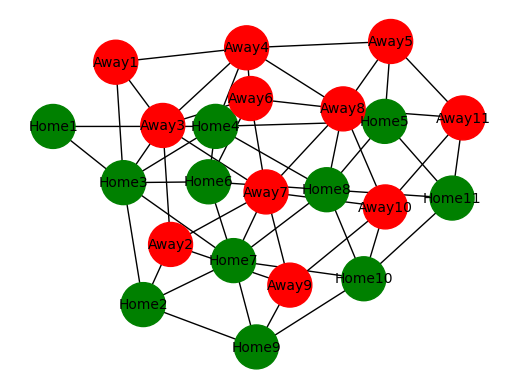

In [10]:
fig, ax = plt.subplots()
pos = nx.spring_layout(SG)
nx.draw(SG, pos, with_labels=True, node_size=1000, node_color=[STATE2COLOR[SG.nodes[node]["state"]] for node in SG.nodes], font_size=10)

## 1 Match

In [21]:
GoalsPositive = 0
GoalsNegative = 0

kickoff = ["Away10", "Home10"]
node = random.choice(kickoff)

for _ in range(45):
    node = update_state(SG, node)
print("\n Half-time! Ball repositioned \n")

if (node == "Away10"):
    halftime = "Home10"
else:
    halftime = "Away10"
    
node = halftime

for _ in range(45):
    node = update_state(SG, node)
    
if (GoalsPositive == GoalsNegative): # Overtime!
    for _ in range(30):
        node = update_state(SG, node)
    
print("\n Match over! \n")
print(GoalsPositive, GoalsNegative)

 🙋🏻‍♂️ Adingra prepares to pass
 👍 Adingra passes to Van Hecke
 🙋🏻‍♂️ Van Hecke prepares to pass
 👍 Van Hecke passes to Verbruggen
 🙋🏻‍♂️ Verbruggen prepares to pass
 👍 Verbruggen passes to Baleba
 🙋🏻‍♂️ Baleba prepares to pass
 👍 Baleba passes to Enciso
 🙋🏻‍♂️ Enciso prepares to pass
 👍 Enciso passes to Lamptey
 🙋🏻‍♂️ Lamptey prepares to pass
 👍 Lamptey passes to Welbeck
 🙋🏻‍♂️ Welbeck prepares to pass
 👍 Welbeck passes to Adingra
 🙋🏻‍♂️ Adingra prepares to pass
 👍 Adingra passes to Dunk
 🙋🏻‍♂️ Dunk prepares to pass
 👍 Dunk passes to Estupinan
 🙋🏻‍♂️ Estupinan prepares to pass
 👍 Estupinan passes to Moder
 🙋🏻‍♂️ Moder prepares to pass
 👍 Moder passes to Baleba
 🙋🏻‍♂️ Baleba prepares to pass
 👍 Baleba passes to Estupinan
 🙋🏻‍♂️ Estupinan prepares to pass
 👍 Estupinan passes to Moder
 🙋🏻‍♂️ Moder prepares to pass
 👍 Moder passes to Estupinan
 🙋🏻‍♂️ Estupinan prepares to pass
 👍 Estupinan passes to Dunk
 🙋🏻‍♂️ Dunk prepares to pass
 👍 Dunk passes to Baleba
 🙋🏻‍♂️ Baleba prepares to pass


## 1000 Matches

In [24]:
results = []
results.clear()
goalResults = []
for i in range (100000):
    GoalsPositive = 0
    GoalsNegative = 0
    kickoff = ["Away10", "Home10"]
    node = random.choice(kickoff)

    for _ in range(45):
        node = update_state(SG, node)
    print("Half-time! Ball repositioned")

    if (node == "Away10"):
        halftime = "Home10"
    else:
        halftime = "Away10"

    node = halftime

    for _ in range(45):
        node = update_state(SG, node)

    if (GoalsPositive == GoalsNegative): # Overtime!
        for _ in range(15):
            node = update_state(SG, node)

    print("Match over!")
    print(GoalsPositive, GoalsNegative)
    
    # Add data of wins/losses
    if GoalsPositive > GoalsNegative:
        results.append(1)
    elif GoalsPositive < GoalsNegative:
        results.append(0)
    
    goalResults.append([GoalsPositive, GoalsNegative])
print (results)

 🙋🏻‍♂️ Adingra prepares to pass
 👍 Adingra passes to Welbeck
 🙋🏻‍♂️ Welbeck prepares to pass
 💨 Welbeck blunders the pass. Adingra and Saka duel for the ball
 💥 Adingra beats Saka in a duel for the ball
 🦵🏻 No opportunities for Adingra, they attempts to dribble
 💨 Adingra failes to dribble. Welbeck and Havertz duel for the ball
 💥 Welbeck beats Havertz in a duel for the ball
 🙋🏻‍♂️ Welbeck prepares to pass
 👍 Welbeck passes to Estupinan
 🙋🏻‍♂️ Estupinan prepares to pass
 👍 Estupinan passes to Baleba
 🙋🏻‍♂️ Baleba prepares to pass
 👍 Baleba passes to Adingra
 🙋🏻‍♂️ Adingra prepares to pass
 👍 Adingra passes to Baleba
 🙋🏻‍♂️ Baleba prepares to pass
 👍 Baleba passes to Verbruggen
 🙋🏻‍♂️ Verbruggen prepares to pass
 👍 Verbruggen passes to Enciso
 🙋🏻‍♂️ Enciso prepares to pass
 👍 Enciso passes to Estupinan
 🙋🏻‍♂️ Estupinan prepares to pass
 💨 Estupinan blunders the pass. Baleba and Zinchenko duel for the ball
 💥 Baleba beats Zinchenko in a duel for the ball
 🙋🏻‍♂️ Baleba prepares to pass
 👍

ZeroDivisionError: float division by zero

## Win statistics

In [26]:
#Win percentages
win = 0
loss = 0
for result in results:
    if result == 1:
        win += 1
    else:
        loss += 1
print ("Win percentage:", (win/(loss+win)*100),"%")
print ("Out of:", win + loss, "matches")

#Confidence interval
import statistics
mean = win/(loss+win)
samplesize = 1000
stddev = statistics.stdev(results)
confidencelevel = 1.64
lower = mean - (stddev/(math. sqrt(samplesize))*confidencelevel)
upper = mean + (stddev/(math. sqrt(samplesize))*confidencelevel)
print("Confidence interval at 5%: [" , round(lower,5) , "<= x <=" , round(upper, 5), "]")

Win percentage: 100.0 %
Out of: 2 matches
Confidence interval at 5%: [ 1.0 <= x <= 1.0 ]


## Graphing visualizations

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Convert data to numpy array
data = np.array(goalResults)

# Mean and covariance matrix
mean = np.mean(data, axis=0)
cov = np.cov(data.T)

# Generate grid points
x = np.linspace(min(data[:, 0]), max(data[:, 0]), 100)
y = np.linspace(min(data[:, 1]), max(data[:, 1]), 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Calculate normal distribution values for each grid point
for i in range(len(x)):
    for j in range(len(y)):
        point = np.array([X[i, j], Y[i, j]])
        Z[i, j] = (1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))) * np.exp(-0.5 * np.dot(np.dot((point - mean), np.linalg.inv(cov)), (point - mean).T))

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], np.zeros_like(data[:, 0]), c='b', marker='o')  # Data points
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)  # Normal distribution surface

# Set labels and title
ax.set_xlabel("Arsenal's goals")
ax.set_ylabel("Shadow's goals")
ax.set_zlabel('Probability')
plt.title('3D Normal Distribution')

# Show the plot
plt.show()

C:\Users\Zhu Shuairong\AppData\Local\Temp\ipykernel_15600\1300284054.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  Z[i, j] = (1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))) * np.exp(-0.5 * np.dot(np.dot((point - mean), np.linalg.inv(cov)), (point - mean).T))


LinAlgError: Singular matrix

In [ ]:
# Mean and covariance matrix
mean = np.mean(data, axis=0)
cov = np.cov(data.T)

# Generate grid points
x = np.linspace(min(data[:, 0]), max(data[:, 0]), 100)
y = np.linspace(min(data[:, 1]), max(data[:, 1]), 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Calculate normal distribution values for each grid point
for i in range(len(x)):
    for j in range(len(y)):
        point = np.array([X[i, j], Y[i, j]])
        Z[i, j] = (1 / (2 * np.pi * np.sqrt(np.linalg.det(cov)))) * np.exp(-0.5 * np.dot(np.dot((point - mean), np.linalg.inv(cov)), (point - mean).T))

# Create the 2D plot
fig, ax = plt.subplots()
ax.contourf(X, Y, Z, levels=20, cmap='viridis')  # Topography plot

# Add colorbar
cbar = plt.colorbar(ax.contourf(X, Y, Z, levels=20, cmap='viridis'))
cbar.ax.set_ylabel('Probability')

# Add data points as scatter plot
ax.scatter(data[:, 0], data[:, 1], c='b', marker='o')  # Data points

ax.plot(x, x, color='red', linestyle='--')

plt.xlim(left=0, right=5)
plt.ylim(bottom=0, top=5)

# Set labels and title
ax.set_xlabel("Arsenal's goals")
ax.set_ylabel("Shadow's goals")
plt.title('2D Normal Distribution Topography')

# Show the plot
plt.show()